<a href="https://colab.research.google.com/github/susiekim101/data-analysis-practice/blob/main/Data_Analysis_Parkinson's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start by importing all of our necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Link our Google Drive so we can have access to our dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load in our dataset from Google Drive

In [ ]:
dataset = pd.read_csv("drive/My Drive/Datasets/beginner_datasets/parkinsons.csv")
# https://drive.google.com/file/d/1VmIbwhYTjz2Y_656ZHcQGJxDspQDpmkr/view?usp=sharing

We'll start off by seeing an overview of what our dataset looks like.

In [ ]:
print("Here's the first 5 rows")
print(dataset.head())
print("Here's the last 5 rows")
print(dataset.tail())

Here's the first 5 rows
   subject#  age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  \
0         1   72    0     5.6431       28.199       34.398    0.00662   
1         1   72    0    12.6660       28.447       34.894    0.00300   
2         1   72    0    19.6810       28.695       35.389    0.00481   
3         1   72    0    25.6470       28.905       35.810    0.00528   
4         1   72    0    33.6420       29.187       36.375    0.00335   

   Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  ...  Shimmer(dB)  Shimmer:APQ3  \
0     0.000034     0.00401      0.00317  ...        0.230       0.01438   
1     0.000017     0.00132      0.00150  ...        0.179       0.00994   
2     0.000025     0.00205      0.00208  ...        0.181       0.00734   
3     0.000027     0.00191      0.00264  ...        0.327       0.01106   
4     0.000020     0.00093      0.00130  ...        0.176       0.00679   

   Shimmer:APQ5  Shimmer:APQ11  Shimmer:DDA       NHR     HNR     RPDE  \
0       0.01

Quite overwhelming, but we can also get some more information by seeing what the datatypes of all the columns are.

In [ ]:
print(dataset.dtypes)

subject#           int64
age                int64
sex                int64
test_time        float64
motor_UPDRS      float64
total_UPDRS      float64
Jitter(%)        float64
Jitter(Abs)      float64
Jitter:RAP       float64
Jitter:PPQ5      float64
Jitter:DDP       float64
Shimmer          float64
Shimmer(dB)      float64
Shimmer:APQ3     float64
Shimmer:APQ5     float64
Shimmer:APQ11    float64
Shimmer:DDA      float64
NHR              float64
HNR              float64
RPDE             float64
DFA              float64
PPE              float64
dtype: object


We can also find out the shape of our dataset.

In [ ]:
dataset.shape

(5875, 22)

Otherwise, we can specifically find the number of columns that are numerical or categorical by separating the dataset with the .select_dtypes() method and printing its shape

In [ ]:
print(dataset.select_dtypes(include=np.number).shape)
print(dataset.select_dtypes(include=['object']).shape)

(5875, 22)
(5875, 0)


Find out if there are any NAs in the dataset by column

In [ ]:
dataset.isnull().sum()

,0
subject#,0
age,0
sex,0
test_time,0
motor_UPDRS,0
total_UPDRS,0
Jitter(%),0
Jitter(Abs),0
Jitter:RAP,0
Jitter:PPQ5,0


We'll just extract the features of this dataset that we'll be needing for this data analysis. Instead of extracing these columns, you can also use the drop function to drop specific columns.

In [ ]:
features = dataset[['subject#', 'motor_UPDRS', 'Jitter(%)', 'Shimmer', 'NHR', 'HNR']]

In [ ]:
dataset = dataset.drop(['test_time', 'Jitter(Abs)', 'Jitter:PPQ5', 'Jitter:RAP', 'Jitter:DDP', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'DFA'], axis = 1)

Next, we've implemented a function that will help identify outliers in all of the remaining columns and immediately drop any rows containing outliers

In [ ]:
def outlier(df):
  Q1 = df.select_dtypes(include=np.number).quantile(0.25)
  Q3 = df.select_dtypes(include=np.number).quantile(0.75)
  IQR = Q3 - Q1
  return df[~((df.select_dtypes(include=np.number) < (Q1 - 1.5 * IQR)) | (df.select_dtypes(include=np.number) > (Q3 + 1.5 * IQR))).any(axis=1)]

outlier(features)

,subject#,motor_UPDRS,Jitter(%),Shimmer,NHR,HNR
0,1,28.199,0.00662,0.02565,0.014290,21.640
1,1,28.447,0.00300,0.02024,0.011112,27.183
2,1,28.695,0.00481,0.01675,0.020220,23.047
3,1,28.905,0.00528,0.02309,0.027837,24.445
4,1,29.187,0.00335,0.01703,0.011625,26.126
...,...,...,...,...,...,...
5870,42,22.485,0.00406,0.01896,0.025137,22.369
5871,42,21.988,0.00297,0.02315,0.011927,22.886
5872,42,21.495,0.00349,0.02499,0.017701,25.065
5873,42,21.007,0.00281,0.01484,0.007984,24.422


We can see that our dataset has multiple rows of data for each subject. This was because the data was tracked and accumulated over time for each individual. Since we want to just focus on every unique subject in the study, we'll calculate the mean for every feature for each individual. We're left with 42 rows each representing a unique subject in the study.

In [ ]:
features = features.groupby('subject#').mean().reset_index()
features

,subject#,motor_UPDRS,Jitter(%),Shimmer,NHR,HNR
0,1,31.898933,0.004284,0.021463,0.018076,25.453027
1,2,13.812538,0.006721,0.041964,0.025089,20.079048
2,3,27.124785,0.003318,0.015841,0.010999,25.687417
3,4,15.790825,0.004967,0.053324,0.031695,19.723737
4,5,31.632603,0.004937,0.036912,0.023780,20.658096
5,6,27.531692,0.006001,0.041061,0.026720,20.998878
6,7,16.047062,0.006258,0.030693,0.028379,20.680248
7,8,19.887020,0.006693,0.032741,0.051060,22.366340
8,9,18.312362,0.010554,0.033898,0.034440,20.412250
9,10,13.424419,0.005555,0.022734,0.027754,23.501466


# Generic Data Analysis

Essentially, we eliminated the test_time column completely from our original data set, but we can also track how motor_UPDRS - a reliable indicator of Parkinson's disease - develops over time.
We can do this by finding the average of each column after grouping each row by subject and plotting the motor_UPDRS against test_time.

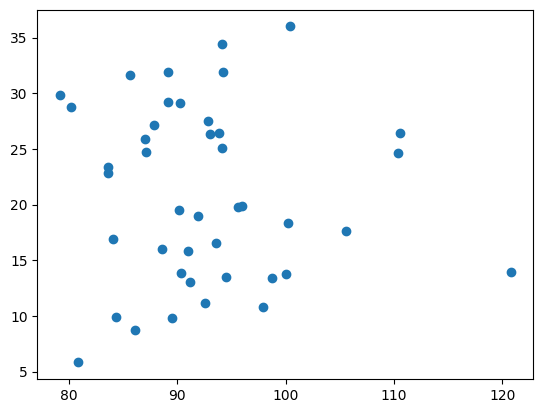

In [ ]:
avg_values = dataset.groupby('subject#').mean()
plt.scatter(avg_values['test_time'], avg_values['motor_UPDRS'])

Back to our original, extracted features Data Frame, we'll plot a heatmap to get an idea of the correlation between each variable

,subject#,motor_UPDRS,Jitter(%),Shimmer,NHR,HNR
subject#,1.000000,0.251049,0.246203,0.203837,0.232638,-0.265902
motor_UPDRS,0.251049,1.000000,0.181275,0.171867,0.126266,-0.251115
Jitter(%),0.246203,0.181275,1.000000,0.862031,0.876876,-0.807634
Shimmer,0.203837,0.171867,0.862031,1.000000,0.907892,-0.869733
NHR,0.232638,0.126266,0.876876,0.907892,1.000000,-0.734923
HNR,-0.265902,-0.251115,-0.807634,-0.869733,-0.734923,1.000000


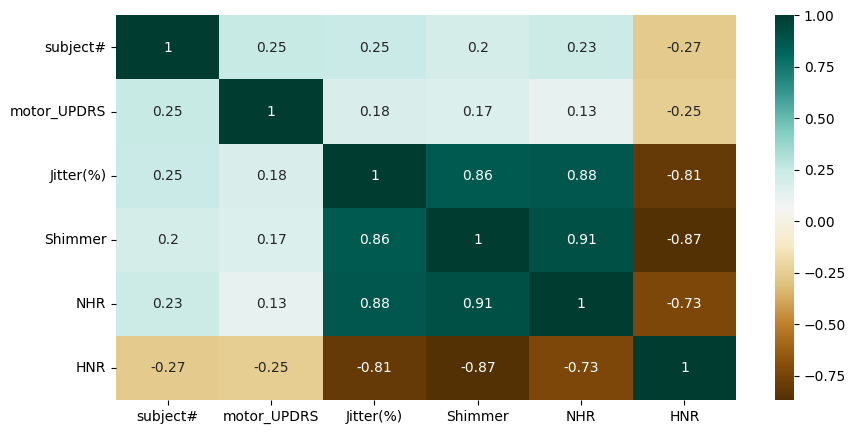

In [ ]:
plt.figure(figsize=(10,5))
c = features.select_dtypes(include='number').corr()
sns.heatmap(c,cmap="BrBG",annot=True)

c


We can see that none of these features alone yields a good measure for predicting motor_UPDRS. However, we can see how some of the features are highly correlated with one another, such as 'Shimmer' and 'NHR'.

The pairplot helps to see another visual representation of each feature in our dataset. This pairplot takes the original dataset without averaging each participant's data, but instead uses "sex" as a measure of differentiation.

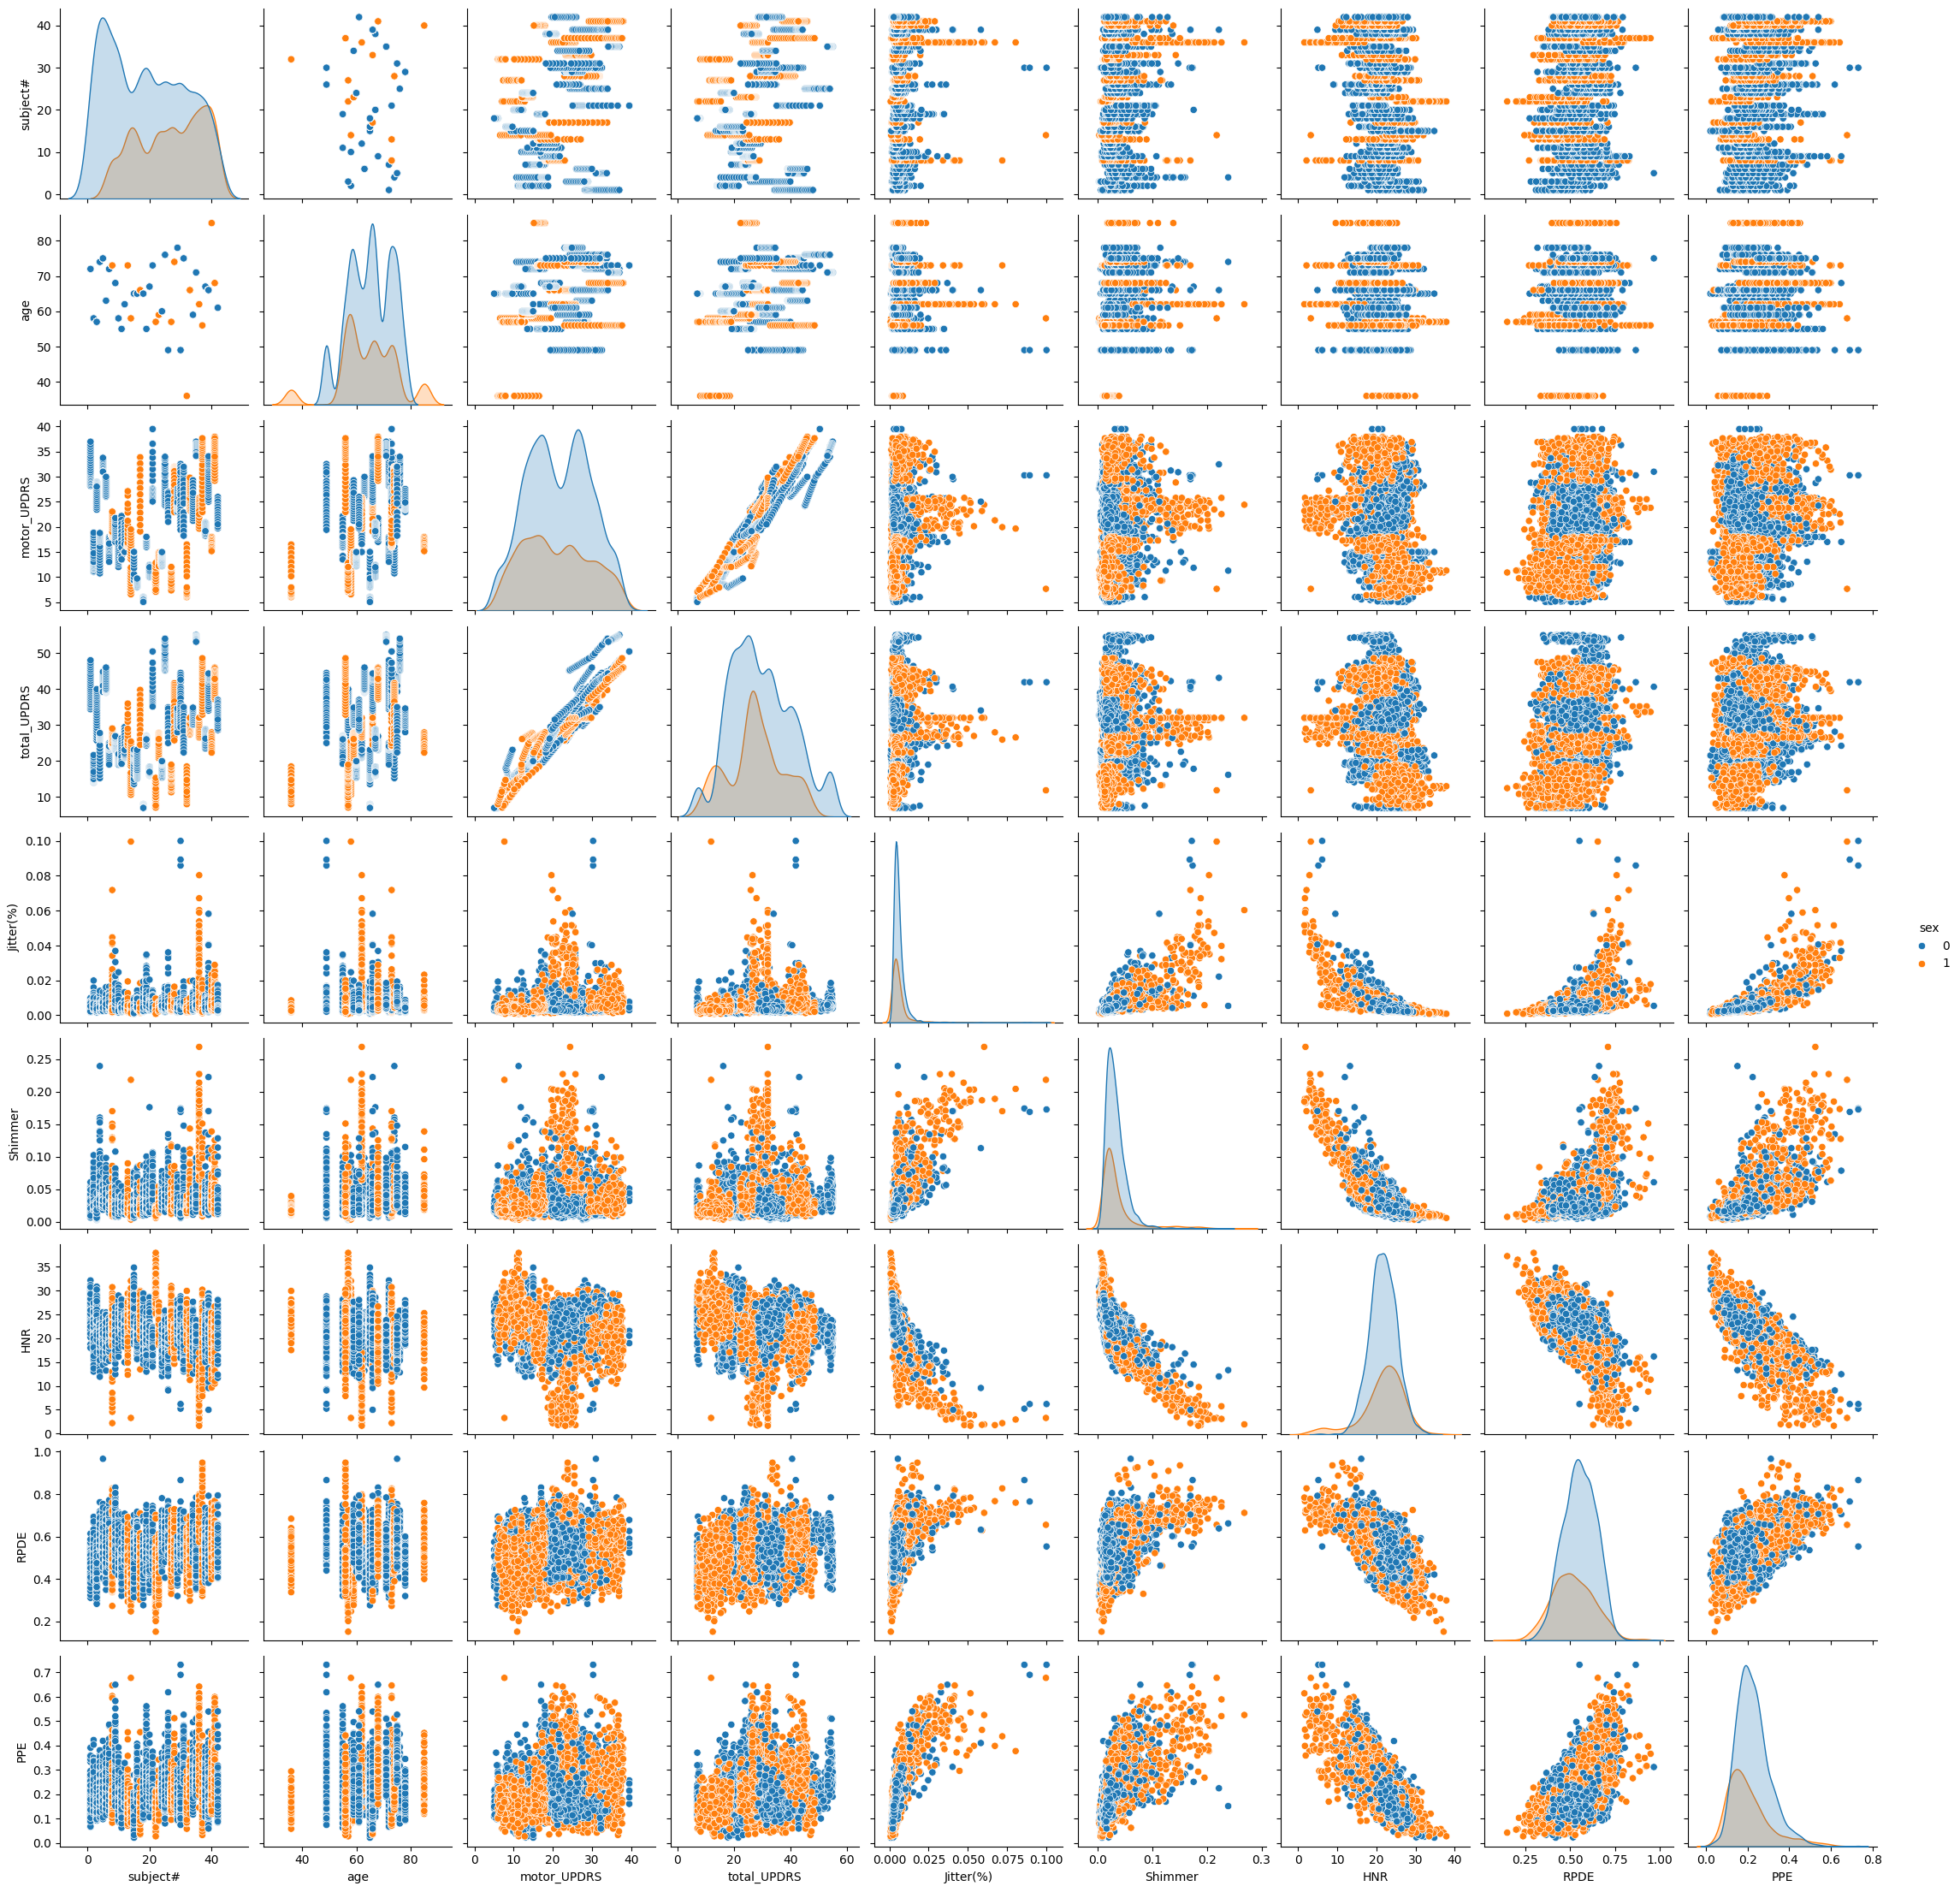

In [ ]:
sns.pairplot(dataset, hue = "sex")
# each color shows that difference in the species
plt.show()

At a quick glance, it seems like there is a tendency for females and males to form clusters with shimmer, jitter, and HNR. This may be due to the fact that shimmer, jitter, and HNR are features extracted from a voice recording. Therefore, females may typically have higher pitch, explaining the tendency to have higher shimmer or jitter values.

# In-Depth Analysis with Scatterplots

We'll first create scatterplots of a few variables we're interested in investigating.

We can see a strong, positive, linear correlation between motor_UPDRS and total_UPDRS, due to the fact that motor_UPDRS represents a clinical score evaluating motor symptoms while total_UPDRS indicates overall clinical score, including non-motor symptoms. They are highly related to one another.

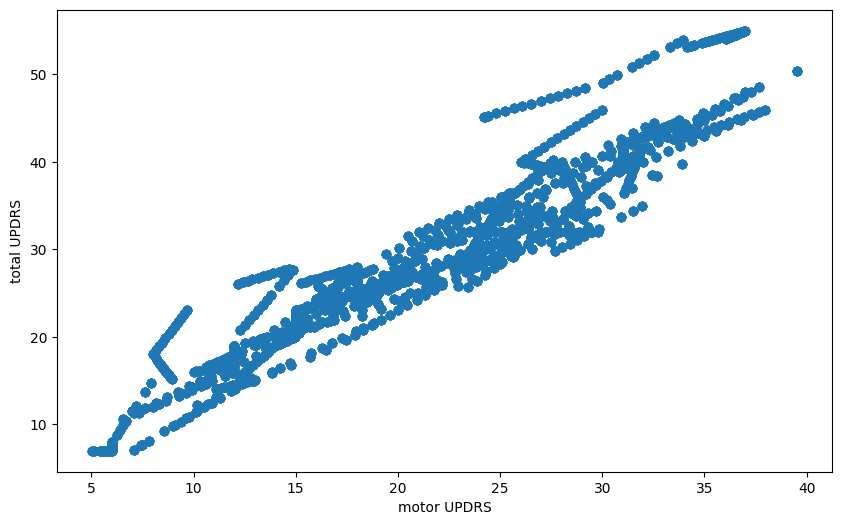

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.scatter(dataset['motor_UPDRS'], dataset['total_UPDRS'])
ax.set_xlabel('motor UPDRS')
ax.set_ylabel('total UPDRS')

plt.show()

We've now plotted the Jitter (variation in pitch) against NHR (noise-to-harmonic ratio). The scatterplot shows a positive linear relationship with one possible outlier.

<function matplotlib.pyplot.show(close=None, block=None)>

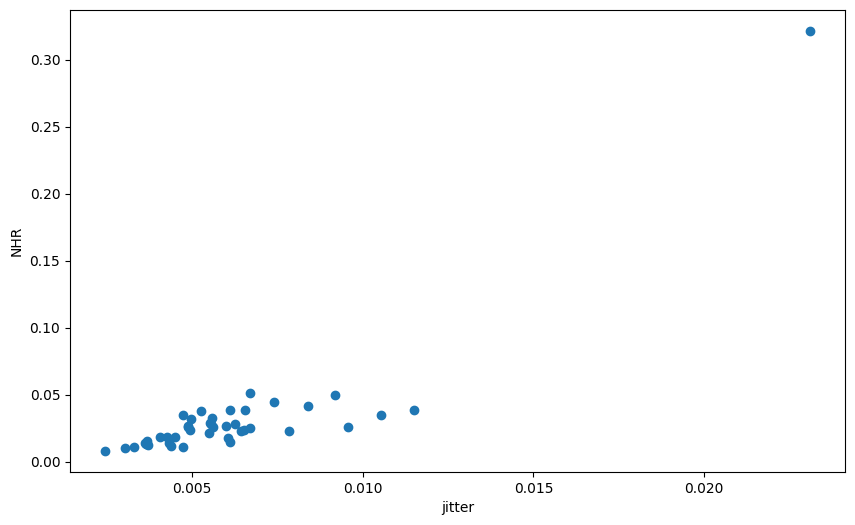

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.scatter(features['Jitter(%)'], features['NHR'])
ax.set_xlabel('jitter')
ax.set_ylabel('NHR')

plt.show

We see a similar relationship with the Shimmer and NHR features from drawing a scatterplot.

<function matplotlib.pyplot.show(close=None, block=None)>

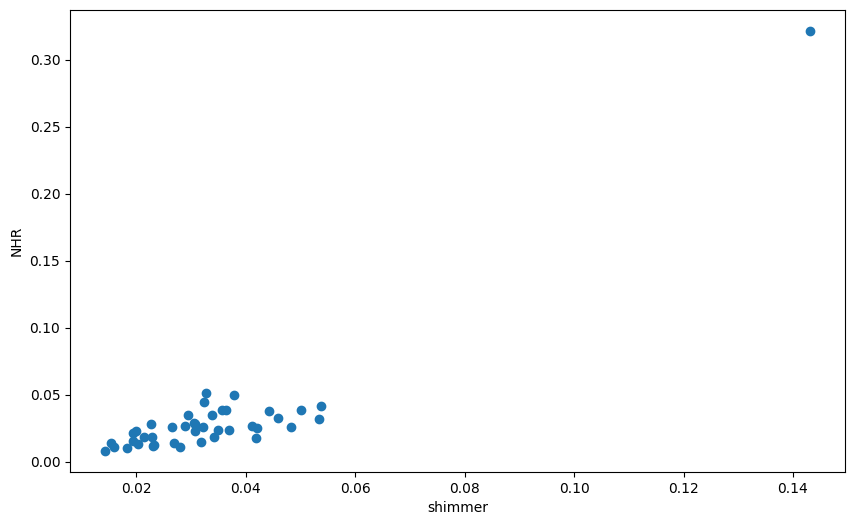

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.scatter(features['Shimmer'], features['NHR'])
ax.set_xlabel('shimmer')
ax.set_ylabel('NHR')

plt.show

We can also plot Shimmer and Jitter to verify the positive, linear relationship.

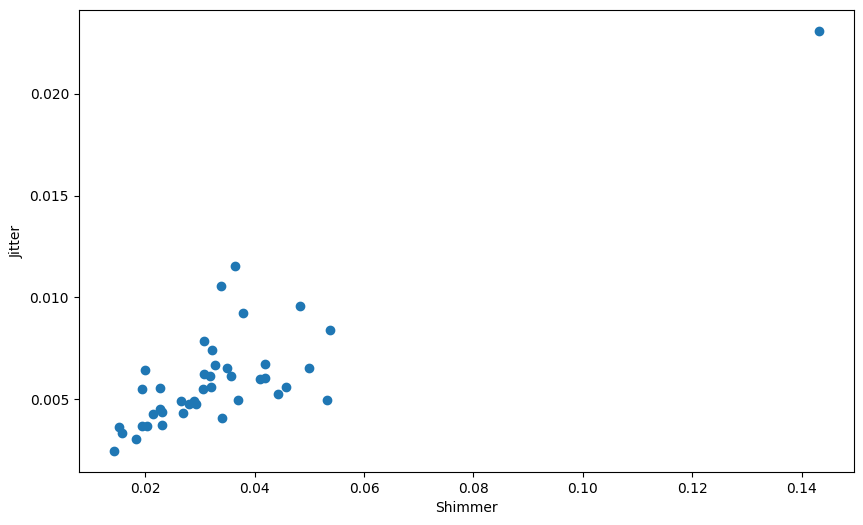

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.scatter(features['Shimmer'], features['Jitter(%)'])
ax.set_xlabel('Shimmer')
ax.set_ylabel('Jitter')

plt.show()

# Linear Regression

Now, we can use the Jitter and Shimmer features to create a linear regression equation to predict NHR.

In [ ]:
from sklearn import linear_model

In [ ]:
model1 = linear_model.LinearRegression()

In [ ]:
model1.fit(X = pd.DataFrame(features[["Jitter(%)"]]),  y = features["NHR"])

LinearRegression()

In [ ]:
print(model1.intercept_)

print(model1.coef_)

0.003417211399820177
[3.79976093]


So, our model is
NHR = -0.00342 + 3.780 * Jitter(%)

After getting our linear regression equation, we can train and test our data.

(Dropping one column that was a visible outlier and was hard to fit in the scaling of the scatterplot)

In [ ]:
features = features.drop(index=features.index[35])

Text(0.5, 1.0, 'Simple Linear Regression')

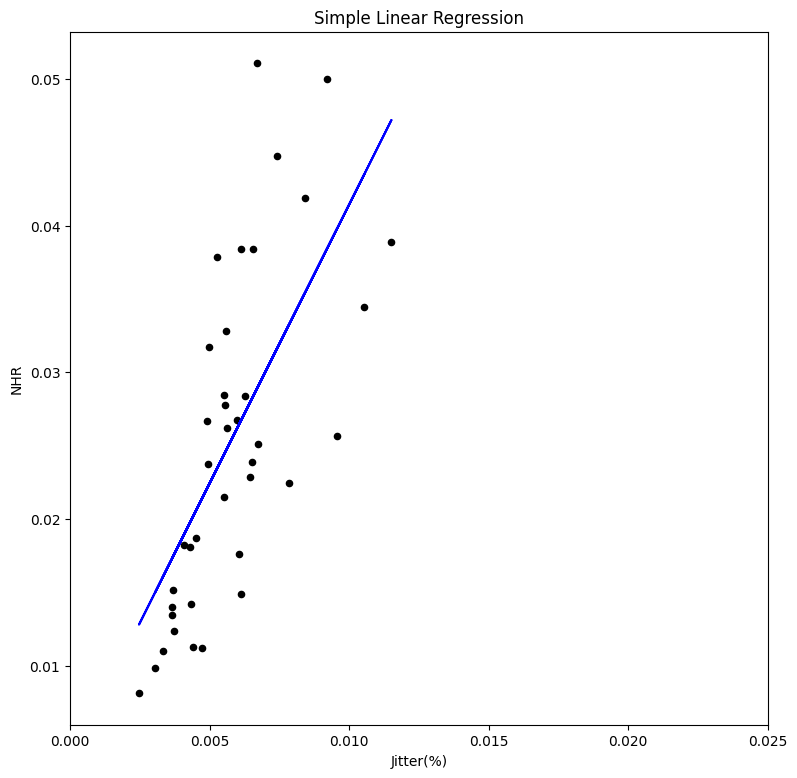

In [ ]:
train_prediction = model1.predict(X = pd.DataFrame(features[["Jitter(%)"]]))

features.plot(kind="scatter",
           x="Jitter(%)",
           y="NHR",
           figsize=(9,9),
           color="black",
           xlim = (0,0.025))

# Plot regression line
plt.plot(features["Jitter(%)"],      # Explanitory variable
         train_prediction,  # Predicted values
         color="blue")

plt.title('Simple Linear Regression')

Calculate the R^2 value, how much the variance of NHR is explained by Jitter(%)

In [ ]:
model1.score(X = pd.DataFrame(features["Jitter(%)"]),
                       y = features["NHR"])

0.47536518061910016

We can also model the a similar linear regression plot for Shimmer and NHR

0.0039035243447586958
[0.67082984]


Text(0.5, 1.0, 'Simple Linear Regression')

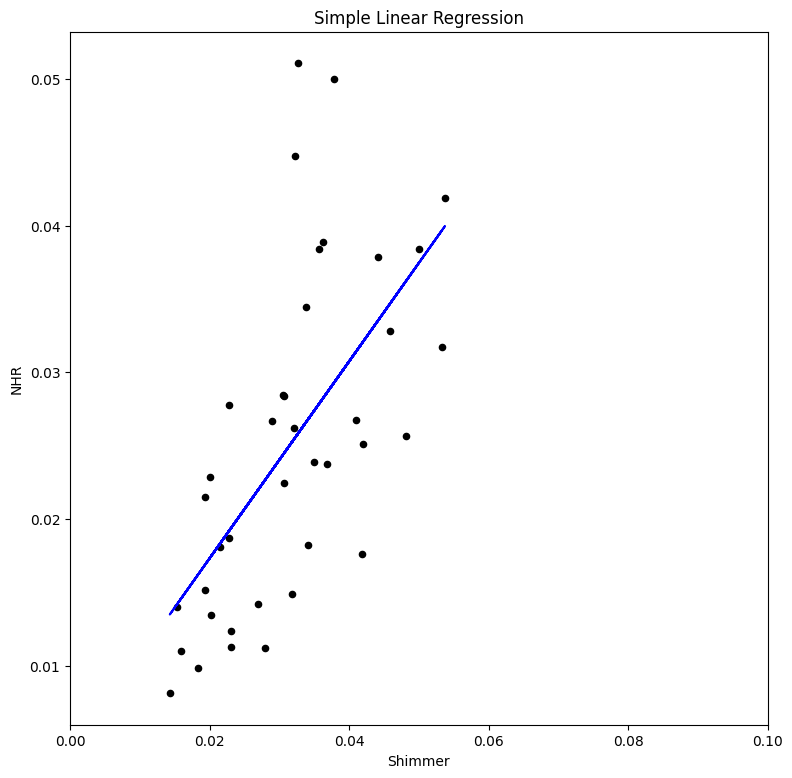

In [ ]:
model2 = linear_model.LinearRegression()
model2.fit(X = pd.DataFrame(features[["Shimmer"]]),  y = features["NHR"])
print(model2.intercept_)

print(model2.coef_)

train_prediction = model2.predict(X = pd.DataFrame(features[["Shimmer"]]))

features.plot(kind="scatter",
           x="Shimmer",
           y="NHR",
           figsize=(9,9),
           color="black",
           xlim = (0,0.1))

# Plot regression line
plt.plot(features["Shimmer"],      # Explanitory variable
         train_prediction,  # Predicted values
         color="blue")

plt.title('Simple Linear Regression')

The equation is
NHR = 0.00390 + 0.671 * Shimmer, and the R^2 value is 0.397

In [ ]:
model2.score(X = pd.DataFrame(features["Shimmer"]),
                       y = features["NHR"])

0.3969268220594727

And Shimmer and Jitter...

0.002458416003030872
[0.10554192]


Text(0.5, 1.0, 'Simple Linear Regression')

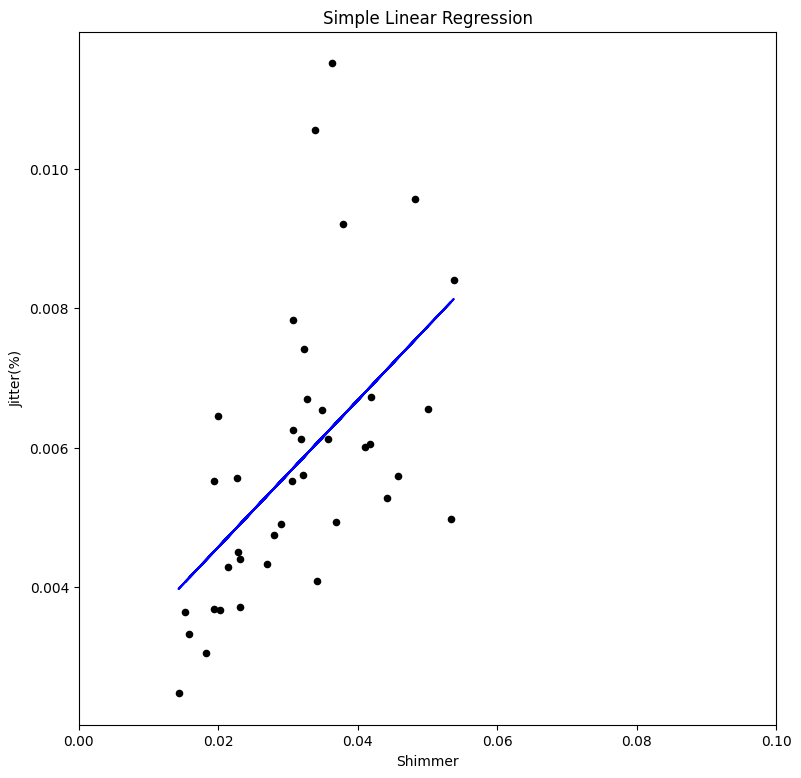

In [ ]:
model3 = linear_model.LinearRegression()
model3.fit(X = pd.DataFrame(features[["Shimmer"]]),  y = features["Jitter(%)"])
print(model3.intercept_)

print(model3.coef_)

train_prediction = model3.predict(X = pd.DataFrame(features[["Shimmer"]]))

features.plot(kind="scatter",
           x="Shimmer",
           y="Jitter(%)",
           figsize=(9,9),
           color="black",
           xlim = (0,0.1))

# Plot regression line
plt.plot(features["Shimmer"],      # Explanitory variable
         train_prediction,  # Predicted values
         color="blue")

plt.title('Simple Linear Regression')

jitter = 0.00246 + 0.106 * Shimmer

In [ ]:
model3.score(X = pd.DataFrame(features["Shimmer"]),
                       y = features["Jitter(%)"])

0.31164690255246563

Based on these models, we can use the shimmer and jitter features to predict NHR which is one of the many factors used to predict Parkinson's disease.